In [33]:
%%script false --no-raise-error

%%bash
pip3 install numpy
pip3 install pandas
pip3 install matplotlib==3.7.0
pip3 install tikzplotlib

In [34]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from pathlib import Path

In [35]:
from packaging.version import Version
if Version(matplotlib.__version__) > Version('3.7.0'):
    raise RuntimeWarning('tikzplotlib cant work with matplotlib > 3.7')

import tikzplotlib
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

In [36]:
ROOT_PATH = Path('./..')

LATEX_PATH = ROOT_PATH / 'paper'

RESOURCES_PATH = ROOT_PATH / 'resources'

CPP_BUILD_PATH = ROOT_PATH / 'build'
STATES_CVS_PATH = RESOURCES_PATH / 'sim_1.csv'

# Расходно напорная характеристика

In [37]:
# initials
P = np.array([2808.80274448953, 2964.84734140562, 2902.42950263918, 2715.17598633988, 2496.71355065736, 2325.06449404967, 2059.78867929232, 1279.5656947119, 592.969468281124])
Q = np.array([0, 5.58329944639905, 11.1665988927981, 16.7498983391972, 22.3331977855962, 25.1248475087957, 27.9164972319952, 33.4997966783943, 37.9664362355135])

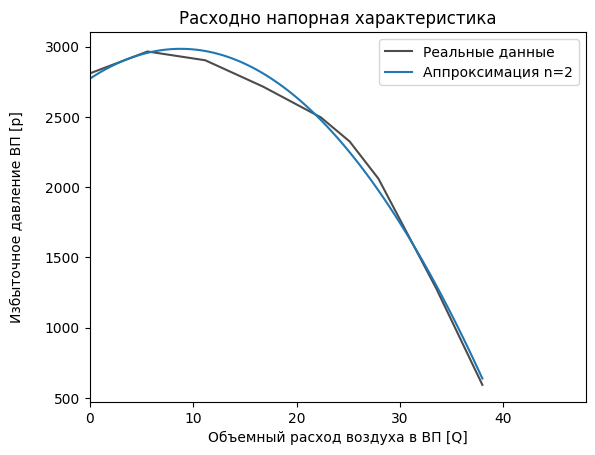

In [38]:
fig, ax = plt.subplots()

ax.plot(Q, P, 'k', label='Реальные данные', alpha=0.7)

_z = np.polyfit(Q, P, 2)
_p = np.poly1d(_z)
_dp = _p.deriv()
_xp = np.linspace(Q.min(), Q.max(), 100)
ax.plot(_xp, _p(_xp), label=f'Аппроксимация n={2}')

ax.set_xlabel('Объемный расход воздуха в ВП [Q]')
ax.set_ylabel('Избыточное давление ВП [p]', labelpad=15)
ax.set_xlim(Q.min(), Q.max() + 10)
plt.title('Расходно напорная характеристика')
plt.legend()
plt.plot();

# tikzplotlib_fix_ncols(fig)
# tikzplotlib.save(LATEX_PATH / 'graph_tikz.tex')


In [39]:
print('Квадратичная функция: ', _p, sep='\n')
A, B, C = _p.coefficients
q_max = 8.791162734091653
print('Вершина параболы:', -B / 2 / A)
print('Максимальное давление:', _p(q_max))

Квадратичная функция: 
        2
-2.756 x + 48.46 x + 2771
Вершина параболы: 8.791162734091653
Максимальное давление: 2983.8648146802116


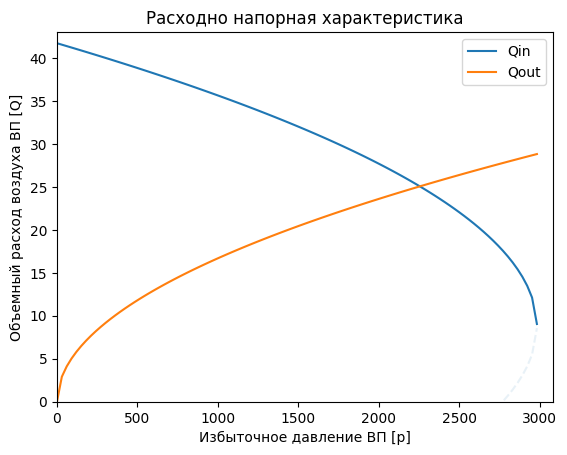

In [40]:
def Qin(p: float, right=True) -> float:
    A = -2.756
    B = 48.46
    C = 2771

    D = B * B - 4 * A * (C - p)
    if right:
        return (-B - np.sqrt(D)) / 2 / A
    return (-B + np.sqrt(D)) / 2 / A


def Qout(p: float) -> float:
    Sgap = 0.42
    rho = 1.269
    chi = 1
    return chi * np.sqrt(2 * p / rho) * Sgap


def maxP() -> float:
    Qtop = -B / 2 / A
    lo = 0.0
    hi = A * Qtop * Qtop + B * Qtop + C
    return hi


fig, ax = plt.subplots()
_xp = np.linspace(0, maxP(), 100, endpoint=True)
ax.plot(_xp, Qin(_xp), label='Qin')
ax.plot(_xp, Qin(_xp, right=False), 'C0--', alpha=0.1)
ax.plot(_xp, Qout(_xp), label='Qout')
# ax.plot(_xp, Qin(_xp) - Qout(_xp), label='Qin - Qout')
ax.set_xlim(0, maxP() + 100)
ax.set_ylim(0, 43)
ax.set_ylabel('Объемный расход воздуха ВП [Q]')
ax.set_xlabel('Избыточное давление ВП [p]')
plt.title('Расходно напорная характеристика')
plt.legend()
plt.plot();

# tikzplotlib_fix_ncols(fig)
# tikzplotlib.save(LATEX_PATH / 'graph2_tikz.tex')

## Визуализация состояний системы

In [41]:
SIMULATION_DT = 1e-6

df = pd.read_csv(STATES_CVS_PATH, delimiter='\t')
df['dt'] = df.index * SIMULATION_DT
df.head(10)

,H,W,S_gap,V_y,phi,p,Q_in,Q_out,dW/dt,dp/dt,Unnamed: 10,dt
0,0.35,31.5,0.0,-0.000010,0.0,0.185319,41.6967,0.0,-7.105430e-15,185319.0,NaN,0.000000
1,0.35,31.5,0.0,-0.000020,0.0,0.370633,41.6957,0.0,-8.819970e-10,185314.0,NaN,0.000001
2,0.35,31.5,0.0,-0.000029,0.0,0.555942,41.6947,0.0,-1.763890e-09,185310.0,NaN,0.000002
3,0.35,31.5,0.0,-0.000039,0.0,0.741247,41.6936,0.0,-2.645730e-09,185305.0,NaN,0.000003
4,0.35,31.5,0.0,-0.000049,0.0,0.926548,41.6926,0.0,-3.527430e-09,185300.0,NaN,0.000004
5,0.35,31.5,0.0,-0.000059,0.0,1.111840,41.6916,0.0,-4.409060e-09,185296.0,NaN,0.000005
6,0.35,31.5,0.0,-0.000069,0.0,1.297140,41.6906,0.0,-5.290590e-09,185291.0,NaN,0.000006
7,0.35,31.5,0.0,-0.000078,0.0,1.482420,41.6895,0.0,-6.172030e-09,185287.0,NaN,0.000007
8,0.35,31.5,0.0,-0.000088,0.0,1.667700,41.6885,0.0,-7.053380e-09,185282.0,NaN,0.000008
9,0.35,31.5,0.0,-0.000098,0.0,1.852980,41.6875,0.0,-7.934630e-09,185278.0,NaN,0.000009


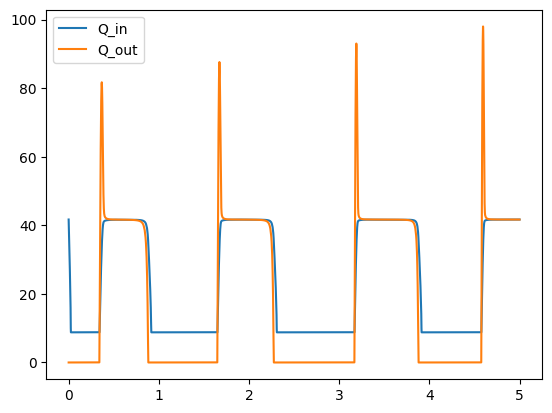

In [42]:
fig, ax = plt.subplots()
ax.plot(df['dt'], df['Q_in'], label='Q_in')
ax.plot(df['dt'], df['Q_out'], label='Q_out')
plt.legend()
plt.plot();

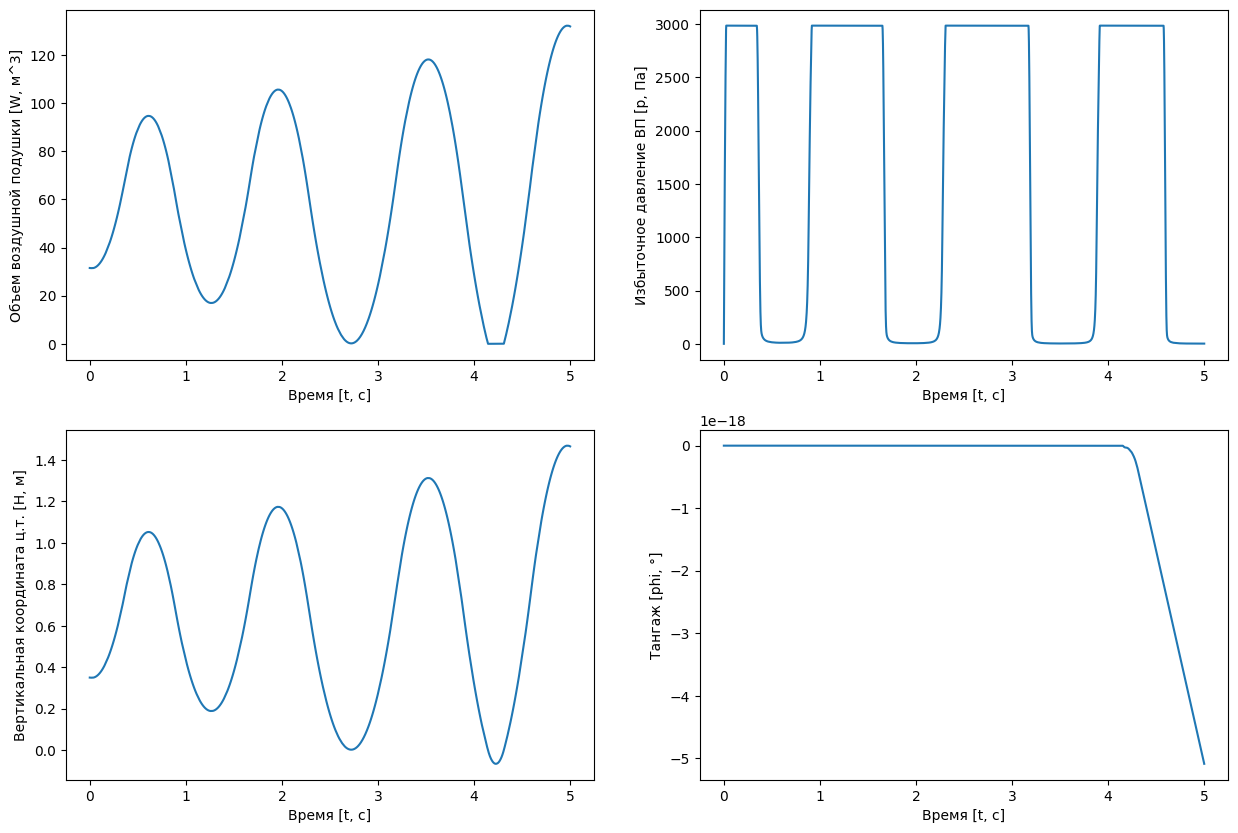

In [45]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(df['dt'], df['W'])
ax1.set_ylabel('Объем воздушной подушки [W, м^3]')
ax1.set_xlabel('Время [t, с]')

ax2.plot(df['dt'], df['p'])
ax2.set_ylabel('Избыточное давление ВП [p, Па]')
ax2.set_xlabel('Время [t, с]')

ax3.plot(df['dt'], df['H'])
ax3.set_ylabel('Вертикальная координата ц.т. [H, м]')
ax3.set_xlabel('Время [t, с]')

ax4.plot(df['dt'], list(map(math.degrees, df['phi'])))
ax4.set_ylabel('Тангаж [phi, °]')
ax4.set_xlabel('Время [t, с]')

plt.plot();